In [1]:
import numpy as np
import cv2  
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img, img_to_array
import matplotlib.pyplot as plt
import time
from tensorflow.keras.models import load_model
import os, getpass
from dotenv import load_dotenv
import math
import google.generativeai as genai
from PIL import Image


import warnings
warnings.filterwarnings("ignore")


In [2]:
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

In [3]:

checkpoint_filepath_pretrained = r"E:\Deep_Learning\Bug bites test\bugbite_ID-master\best_model_bite.h5"
model = load_model(checkpoint_filepath_pretrained)
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 6, 6, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │        14,343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,817,129 (83.23 MB)

 Trainable params: 21,444,327 (81.80 MB)

 Non-trainable params: 372,800 (1.42 MB)

 Optimizer params: 2 (12.00 B)

None


Found 200 images belonging to 7 classes.
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step
              precision    recall  f1-score   support

        ants       0.95      0.64      0.77        28
    bed_bugs       0.51      0.86      0.64        36
    chiggers       0.68      0.50      0.58        34
       fleas       0.70      0.76      0.73        21
   mosquitos       0.94      0.71      0.81        21
     spiders       0.80      0.71      0.75        28
       ticks       0.81      0.78      0.79        32

    accuracy                           0.71       200
   macro avg       0.77      0.71      0.72       200
weighted avg       0.75      0.71      0.71       200



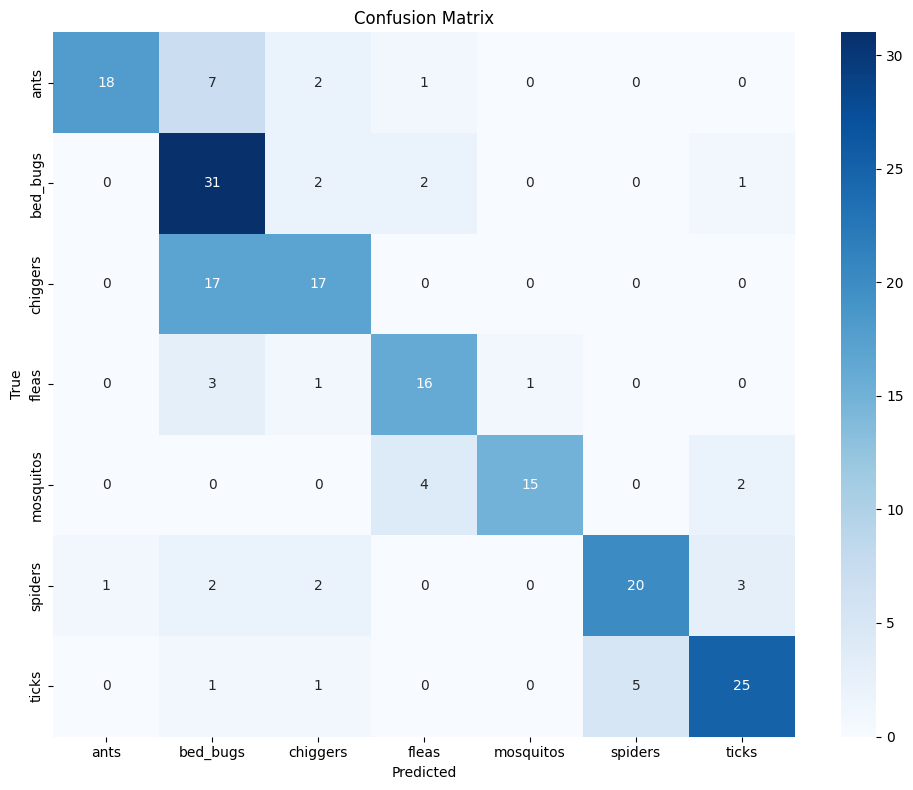

In [4]:
data_dir_test = r"E:\Deep_Learning\Bug bites test\bugbite_ID-master\Resources\images\testing"

model = load_model(checkpoint_filepath_pretrained)

def create_test_generator(test_dir, img_size=(255, 255), batch_size=32):
    """Data generator for test images"""

    test_datagen = ImageDataGenerator(rescale=1./255)
    
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  
    )
    
    return test_generator

test_generator = create_test_generator(data_dir_test)


def evaluate_model(model, test_generator):
    """Evaluate model performance on test data"""
    
    # Reset the generator
    test_generator.reset()
    
    # Get predictions
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Get true classes
    y_true = test_generator.classes
    
    # Get class names
    class_names = list(test_generator.class_indices.keys())
    
    # Print classification report
    print(classification_report(y_true, y_pred_classes, target_names=class_names))
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return y_pred, y_true

# Use after training is complete
y_pred, y_true = evaluate_model(model, test_generator)

In [5]:
model_gemini = genai.GenerativeModel('models/gemini-2.0-flash')

image = r"E:\Deep_Learning\Skin diseases\data_bite\train\fleas\fleas_3.jpg"
image = Image.open(image)

prompt = '''You are a medical image classification assistant.
Given an image of a skin condition, classify it into one of the following categories:

1. Mosquito Bites
2. Bedbug Bites
3. Tick Bites
4. Flea Bites
5. Chigger Bites
6. Spider Bites
7. Ant Bites

Please analyze the image and respond ONLY in the following dictionary format:

{
  "predicted_class": "<class name from above>",
  "prediction_confidences": {
    "Mosquito Bites": <probability between 0 and 1>,
    "Bedbug Bites": <probability between 0 and 1>,
    "Tick Bites": <probability between 0 and 1>,
    "Flea Bites": <probability between 0 and 1>,
    "Chigger Bites": <probability between 0 and 1>,
    "Spider Bites": <probability between 0 and 1>,
    "Ant Bites": <probability between 0 and 1>,
    "Bee Stings": <probability between 0 and 1>
  }
}

Where:
- "predicted_class" is the class with the highest probability.
- "prediction_confidences" is a dictionary with the probability for each class (all values between 0 and 1, and should sum to 1).

If you are unsure, distribute the probabilities accordingly.
'''

prompt_for_classification = '''You are a medical image classification assistant.  
Given an image of a skin condition, classify it into one of the following categories:

1. Mosquito Bites  
2. Bedbug Bites  
3. Tick Bites  
4. Flea Bites  
5. Chigger Bites  
6. Spider Bites  
7. Ant Bites  

Please analyze the image and respond ONLY in the following format:

<predicted_class_1> (<probability_1>), <predicted_class_2> (<probability_2>)

Where:
- <predicted_class_1> is the class with the highest probability.
- <predicted_class_2> is the class with the second highest probability.
- Each <probability> is a number between 0 and 1, rounded to two decimal places.

Example output:
Mosquito Bites (0.87), Bedbug Bites (0.08)

If you are unsure, still return the top two most likely classes based on the prediction confidence.
'''


response = model_gemini.generate_content([prompt_for_classification, image]  )
response.text

'Mosquito Bites (0.75), Spider Bites (0.10)'

In [6]:
CLASS_NAMES = ['ants', 'bed_bugs', 'chiggers' , "fleas" , "mosquitos" , "spiders", "ticks"]
prediction = np.argmax(y_pred,axis=1)
errors = np.where(prediction != y_true)[0]                           # index which image is wrong predicted
imagenames = test_generator.filenames                                # image name


nb_samples = len(imagenames)
predict = model.predict(test_generator, steps=nb_samples)

wrong_file = {}
for i in errors:
    wrong_file[i]=imagenames[i]
    
wrong_predict_dict = {}

for n, (i, name) in enumerate(wrong_file.items()):
    wrong_predict_dict[i] = np.round(predict[i], 3)

len(wrong_predict_dict)

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step   


58

In [7]:
class_count = {class_name: 0 for class_name in CLASS_NAMES}
max_samples_per_class = 2                                   # Only show 2 samples per class

selected_samples = []
paths = list(wrong_file.values())

# Select samples ensuring a maxium of 2 samples per class (for gemini model testing)
for i, _ in wrong_predict_dict.items():
    true_class = CLASS_NAMES[y_true[i]]
    if class_count[true_class] < max_samples_per_class:
        selected_samples.append(i)
        class_count[true_class] += 1

# Display only the selected samples
for idx, i in enumerate(selected_samples):

    row = wrong_predict_dict[i]
    top2_indices = row.argsort()[-2:][::-1]
    top2_classes = [(CLASS_NAMES[j], row[j]) for j in top2_indices]
    response = model_gemini.generate_content([prompt_for_classification, paths[idx]])

    # Display selected image
    print(f"Image {CLASS_NAMES[y_true[i]]} {idx + 1}:")
    for class_name, score in top2_classes:
        print(f"  {class_name}: {round(score, 2)}")
        
    print(f"Gemini model: {response.text}")

    print()

Image ants 1:
  bed_bugs: 0.6299999952316284
  ants: 0.30000001192092896
Gemini model: Ant Bites (0.75), Mosquito Bites (0.10)


Image ants 2:
  bed_bugs: 0.9599999785423279
  chiggers: 0.029999999329447746
Gemini model: Ant Bites (0.75), Mosquito Bites (0.10)


Image bed_bugs 3:
  fleas: 0.6299999952316284
  bed_bugs: 0.23999999463558197
Gemini model: Ant Bites (0.99), Mosquito Bites (0.01)


Image bed_bugs 4:
  chiggers: 0.699999988079071
  bed_bugs: 0.2800000011920929
Gemini model: Ant Bites (0.65), Spider Bites (0.15)


Image chiggers 5:
  bed_bugs: 0.9399999976158142
  chiggers: 0.05999999865889549
Gemini model: Ant Bites (0.65), Spider Bites (0.15)


Image chiggers 6:
  bed_bugs: 0.5299999713897705
  chiggers: 0.44999998807907104
Gemini model: Ant Bites (0.75), Spider Bites (0.10)


Image fleas 7:
  bed_bugs: 0.7200000286102295
  ticks: 0.18000000715255737
Gemini model: Ant Bites (0.62), Spider Bites (0.15)


Image fleas 8:
  chiggers: 0.8100000023841858
  fleas: 0.18000000715255

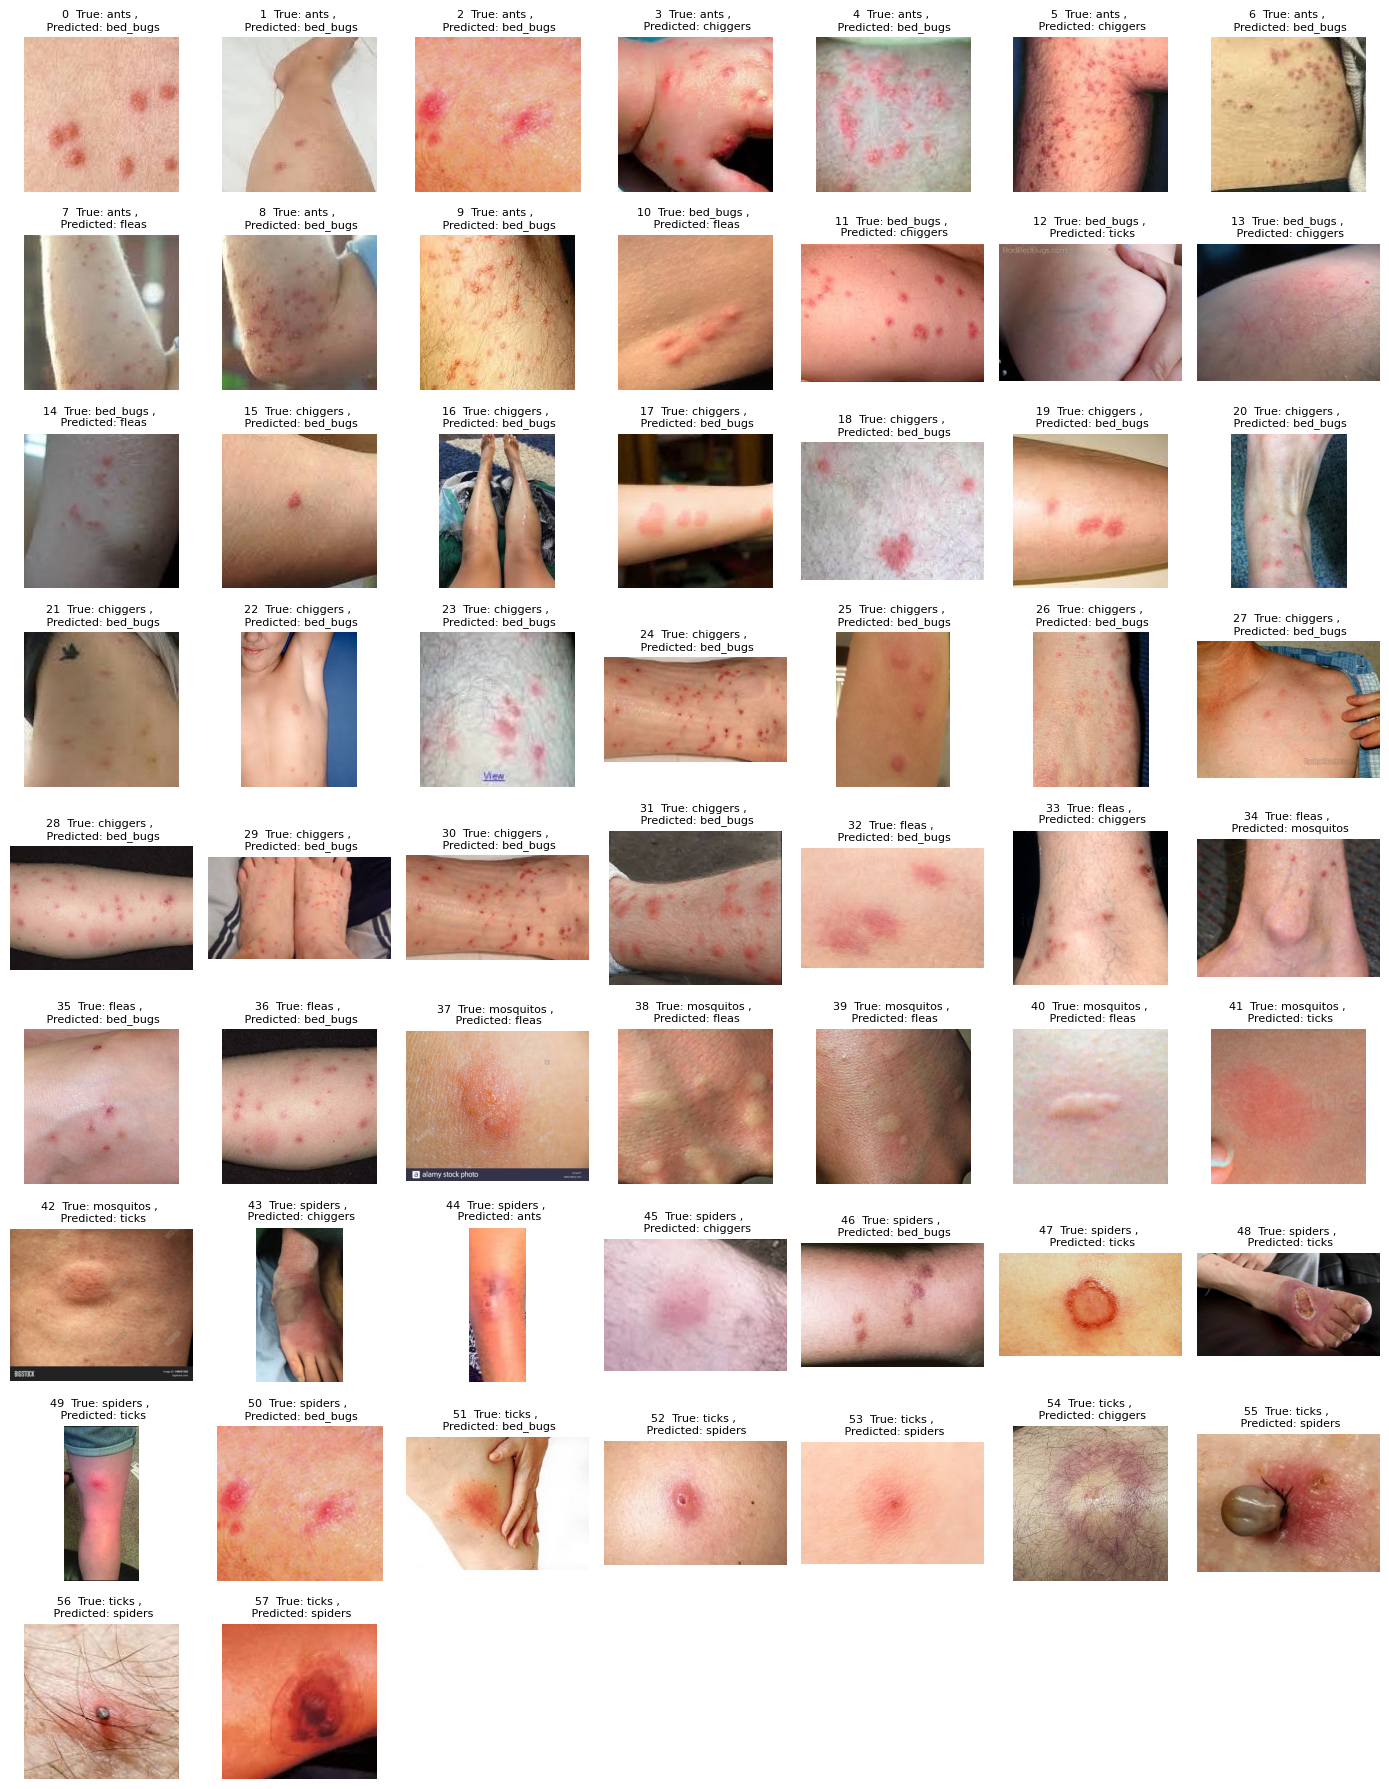

In [8]:
# Count the number of errors, numbers of rows and columns for the plot
num_errors = len(errors)
cols = 7
rows = math.ceil(num_errors / cols)

plt.figure(figsize=(cols * 2, rows * 2))

# Display the images with wrong predictions 
wrong_predict = []
for n, (i, name) in enumerate(wrong_file.items()):
    
    # Load the image and preprocess it for visualization
    img_path = os.path.join(data_dir_test, name)
    img = load_img(img_path)
    img_tensor = img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.

    # Create a subplot for each image, showing the true and predicted classes, for all images
    ax = plt.subplot(rows, cols, n + 1)
    plt.imshow(img_tensor[0] / np.max(img_tensor[0]))  
    plt.title(f"{n}  True: {CLASS_NAMES[y_true[i]]} , \n Predicted: {CLASS_NAMES[prediction[i]]}", fontsize=8)
    plt.axis('off')
    wrong_predict.append(predict[i])

plt.tight_layout()
plt.show()